In [13]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib qt

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.5

# Aliasing: Different Signals, Identical Samples

In [21]:
LOW_FREQ_HZ = 3.0
HIGH_FREQ_HZ = 8.0
SAMPLING_RATE_HZ = 5.0
SIGNAL_DURATION_S = 2.0
CONTINUOUS_RATE_HZ = 1000.0

continuous_time_s = np.arange(0.0, SIGNAL_DURATION_S, 1.0 / CONTINUOUS_RATE_HZ)
low_freq_signal = np.cos(2 * np.pi * LOW_FREQ_HZ * continuous_time_s)
high_freq_signal = np.cos(2 * np.pi * HIGH_FREQ_HZ * continuous_time_s)

sample_times_s = np.arange(0.0, SIGNAL_DURATION_S, 1.0 / SAMPLING_RATE_HZ)
sample_interval = int(CONTINUOUS_RATE_HZ / SAMPLING_RATE_HZ)
sample_indices = np.arange(0, len(continuous_time_s), sample_interval)
low_freq_samples = low_freq_signal[sample_indices]
high_freq_samples = high_freq_signal[sample_indices]

fig, ax = plt.subplots()
ax.plot(continuous_time_s, low_freq_signal, 'b-', alpha=0.7, 
        label=f'{LOW_FREQ_HZ} Hz signal')
ax.plot(continuous_time_s, high_freq_signal, 'g-', alpha=0.7, 
        label=f'{HIGH_FREQ_HZ} Hz signal')
ax.plot(sample_times_s, low_freq_samples, 'kx', markersize=8, 
        label=f'Samples of {LOW_FREQ_HZ} Hz (fs = {SAMPLING_RATE_HZ} Hz)')
ax.plot(sample_times_s, high_freq_samples, 'r+', markersize=10, 
        label=f'Samples of {HIGH_FREQ_HZ} Hz (fs = {SAMPLING_RATE_HZ} Hz)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In this example, two different cosines (3 Hz and 8 Hz) sampled at 5 Hz produce the same discrete samples, so we can’t tell them apart from the sampled data alone. This illustrates aliasing: if the sampling rate is too low, the samples no longer uniquely determine the original signal.

# From Time-Domain Sampling to Frequency-Domain Replicas

Sampling a continuous signal is mathematically equivalent to multiplying it by a sampling function. This sampling function is a train of Dirac delta functions (impulses) spaced at intervals of $T_s = \frac{1}{f_s}$:
$$s(t) = \sum_{n=-\infty}^{\infty} \delta(t - nT_s)$$
where $f_s$ is the sampling rate.

The fourier transform of the sampling function is:

$$
S(f) = \int_{-\infty}^{\infty} \left(\sum_{n=-\infty}^{\infty} \delta(t - nT_s)\right) e^{-i 2\pi f t}\, dt
$$

$$
S(f) = \sum_{n=-\infty}^{\infty} \int_{-\infty}^{\infty} \delta(t - nT_s)\, e^{-i 2\pi f t}\, dt
$$

Using the shifting property of the dirac:
$$
\int_{-\infty}^{\infty} \delta(t - nT_s)\, e^{-i 2\pi f t}\, dt
= e^{-i 2\pi f (nT_s)}
$$

We have

$$
S(f) = \sum_{n=-\infty}^{\infty} e^{-i 2\pi f n T_s}
$$

Using the Poisson summation identity:

$$
\sum_{n=-\infty}^{\infty} e^{-i 2\pi f n T_s}
= \frac{1}{T_s} \sum_{k=-\infty}^{\infty} \delta\!\left(f - k f_s\right)
$$

Therefore:

$$
S(f) = \frac{1}{T_s} \sum_{k=-\infty}^{\infty} \delta\!\left(f - k f_s\right)
$$

The result indicates that sampling a signal in the time domain leads to periodic repetitions of its spectrum in the frequency domain, since multiplying in time corresponds to convolution in frequency


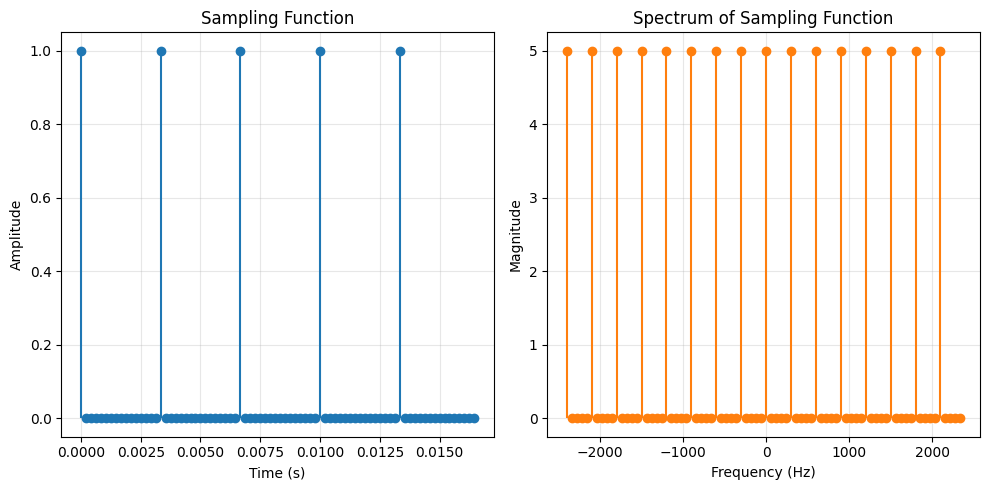

In [11]:
SAMPLING_RATE_HZ = 300.0
NUM_SAMPLE_PERIODS = 5
SIGNAL_DURATION_S = NUM_SAMPLE_PERIODS / SAMPLING_RATE_HZ
CONTINUOUS_RATE_HZ = 4800.0

continuous_time_s = np.arange(0.0, SIGNAL_DURATION_S, 1.0 / CONTINUOUS_RATE_HZ)
sampling_function = np.zeros_like(continuous_time_s)
sample_times_s = np.arange(0.0, SIGNAL_DURATION_S, 1.0 / SAMPLING_RATE_HZ)
sample_indices = np.round(sample_times_s * CONTINUOUS_RATE_HZ).astype(int)
sampling_function[sample_indices] = 1.0

sampling_spectrum = np.fft.fft(sampling_function)
sampling_freqs_hz = np.fft.fftfreq(len(sampling_function), d=1.0 / CONTINUOUS_RATE_HZ)
sampling_spectrum_shifted = np.fft.fftshift(sampling_spectrum)
sampling_freqs_shifted_hz = np.fft.fftshift(sampling_freqs_hz)
sampling_spectrum_mag = np.abs(sampling_spectrum_shifted)

fig, (ax_time, ax_freq) = plt.subplots(1, 2)

ax_time.stem(continuous_time_s, sampling_function, basefmt=' ', linefmt='C0-')
ax_time.set_xlabel('Time (s)')
ax_time.set_ylabel('Amplitude')
ax_time.set_title('Sampling Function')
ax_time.grid(True, alpha=0.3)

ax_freq.stem(sampling_freqs_shifted_hz, sampling_spectrum_mag, basefmt=' ', linefmt='C1-')
ax_freq.set_xlabel('Frequency (Hz)')
ax_freq.set_ylabel('Magnitude')
ax_freq.set_title('Spectrum of Sampling Function')
ax_freq.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle

# Create a more interesting bandlimited signal spectrum
def create_original_spectrum(freqs, max_freq=50):
    """Create an interesting multi-peak bandlimited spectrum"""
    spectrum = np.zeros_like(freqs)
    mask = np.abs(freqs) <= max_freq
    
    # Multiple peaks to make it more interesting
    f_masked = freqs[mask]
    
    # Low frequency peak
    peak1 = 0.8 * np.exp(-((f_masked - 0) / 8) ** 2)
    
    # Mid frequency peaks (symmetric)
    peak2 = 0.6 * np.exp(-((f_masked - 25) / 6) ** 2)
    peak3 = 0.6 * np.exp(-((f_masked + 25) / 6) ** 2)
    
    # High frequency components
    peak4 = 0.4 * np.exp(-((f_masked - 40) / 5) ** 2)
    peak5 = 0.4 * np.exp(-((f_masked + 40) / 5) ** 2)
    
    spectrum[mask] = peak1 + peak2 + peak3 + peak4 + peak5
    
    return spectrum

# Parameters
MAX_SIGNAL_FREQ = 50  # Hz - highest frequency in original signal
GOOD_SAMPLING_RATE = 150  # Hz - well above Nyquist (2 * 50 = 100 Hz)
BAD_SAMPLING_RATE = 80   # Hz - below Nyquist, will cause aliasing

# Frequency axis
freqs = np.linspace(-300, 300, 2000)

# Original spectrum (centered at 0)
original_spectrum = create_original_spectrum(freqs, MAX_SIGNAL_FREQ)

# Setup figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('Spectral Convolution: Sampling Creates Periodic Copies', 
             fontsize=15, fontweight='bold')

# Initialize plots
line_orig1, = ax1.plot(freqs, original_spectrum, 'b-', linewidth=2.5, label='Original X(f)', alpha=0.7)
line_orig2, = ax2.plot(freqs, original_spectrum, 'b-', linewidth=2.5, label='Original X(f)', alpha=0.7)

copies1 = []
copies2 = []
for i in range(7):  # Create line objects for copies
    line, = ax1.plot([], [], 'r--', linewidth=1.5, alpha=0.5)
    copies1.append(line)
    line, = ax2.plot([], [], 'r--', linewidth=1.5, alpha=0.5)
    copies2.append(line)

result1, = ax1.plot([], [], 'g-', linewidth=3, label='Convolved result', alpha=0.8)
result2, = ax2.plot([], [], 'g-', linewidth=3, label='Convolved result', alpha=0.8)

# Add 2*f_max boxes showing the bandwidth limits
# Good sampling
nyquist_box1 = Rectangle((-MAX_SIGNAL_FREQ, -0.05), 2*MAX_SIGNAL_FREQ, 0.03, 
                         linewidth=3, edgecolor='purple', facecolor='purple', 
                         alpha=0.3, label=f'Signal BW: 2×{MAX_SIGNAL_FREQ}={2*MAX_SIGNAL_FREQ} Hz')
ax1.add_patch(nyquist_box1)
ax1.axvline(MAX_SIGNAL_FREQ, color='purple', linestyle='--', linewidth=2, alpha=0.6)
ax1.axvline(-MAX_SIGNAL_FREQ, color='purple', linestyle='--', linewidth=2, alpha=0.6)

# Bad sampling
nyquist_box2 = Rectangle((-MAX_SIGNAL_FREQ, -0.05), 2*MAX_SIGNAL_FREQ, 0.03, 
                         linewidth=3, edgecolor='purple', facecolor='purple', 
                         alpha=0.3, label=f'Signal BW: 2×{MAX_SIGNAL_FREQ}={2*MAX_SIGNAL_FREQ} Hz')
ax2.add_patch(nyquist_box2)
ax2.axvline(MAX_SIGNAL_FREQ, color='purple', linestyle='--', linewidth=2, alpha=0.6)
ax2.axvline(-MAX_SIGNAL_FREQ, color='purple', linestyle='--', linewidth=2, alpha=0.6)

# Styling for good sampling
ax1.set_xlim(-300, 300)
ax1.set_ylim(-0.1, 1.8)
ax1.set_xlabel('Frequency (Hz)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Magnitude', fontsize=12, fontweight='bold')
ax1.set_title(f'✓ GOOD: fₛ = {GOOD_SAMPLING_RATE} Hz > {2*MAX_SIGNAL_FREQ} Hz (Nyquist)', 
              fontsize=13, fontweight='bold', color='green')
ax1.axvline(0, color='gray', linestyle=':', alpha=0.5)
ax1.axvline(GOOD_SAMPLING_RATE, color='orange', linestyle=':', alpha=0.7, linewidth=2)
ax1.axvline(-GOOD_SAMPLING_RATE, color='orange', linestyle=':', alpha=0.7, linewidth=2)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', fontsize=10)

# Styling for bad sampling
ax2.set_xlim(-300, 300)
ax2.set_ylim(-0.1, 1.8)
ax2.set_xlabel('Frequency (Hz)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Magnitude', fontsize=12, fontweight='bold')
ax2.set_title(f'✗ BAD: fₛ = {BAD_SAMPLING_RATE} Hz < {2*MAX_SIGNAL_FREQ} Hz (Nyquist) → ALIASING!', 
              fontsize=13, fontweight='bold', color='red')
ax2.axvline(0, color='gray', linestyle=':', alpha=0.5)
ax2.axvline(BAD_SAMPLING_RATE, color='orange', linestyle=':', alpha=0.7, linewidth=2)
ax2.axvline(-BAD_SAMPLING_RATE, color='orange', linestyle=':', alpha=0.7, linewidth=2)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize=10)

# Text annotations
text1 = ax1.text(0.02, 0.95, '', transform=ax1.transAxes, 
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
text2 = ax2.text(0.02, 0.95, '', transform=ax2.transAxes, 
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

# Add spacing indicators
spacing_arrow1 = None
spacing_arrow2 = None

def init():
    for line in copies1 + copies2:
        line.set_data([], [])
    result1.set_data([], [])
    result2.set_data([], [])
    return copies1 + copies2 + [result1, result2, text1, text2]

def animate(frame):
    global spacing_arrow1, spacing_arrow2
    
    # Animation progresses from showing original to adding copies
    n_frames = 100
    progress = frame / n_frames
    
    # Determine which copies to show (gradually add them)
    k_values = [-3, -2, -1, 0, 1, 2, 3]
    n_copies_shown = int(progress * len(k_values))
    
    # Good sampling rate
    result_good = np.zeros_like(freqs)
    for i, k in enumerate(k_values[:n_copies_shown]):
        shift = k * GOOD_SAMPLING_RATE
        shifted_spectrum = create_original_spectrum(freqs - shift, MAX_SIGNAL_FREQ)
        copies1[i].set_data(freqs, shifted_spectrum)
        result_good += shifted_spectrum
    
    # Hide unused copy lines
    for i in range(n_copies_shown, len(copies1)):
        copies1[i].set_data([], [])
    
    result1.set_data(freqs, result_good)
    
    # Bad sampling rate
    result_bad = np.zeros_like(freqs)
    for i, k in enumerate(k_values[:n_copies_shown]):
        shift = k * BAD_SAMPLING_RATE
        shifted_spectrum = create_original_spectrum(freqs - shift, MAX_SIGNAL_FREQ)
        copies2[i].set_data(freqs, shifted_spectrum)
        result_bad += shifted_spectrum
    
    # Hide unused copy lines
    for i in range(n_copies_shown, len(copies2)):
        copies2[i].set_data([], [])
    
    result2.set_data(freqs, result_bad)
    
    # Update text
    if n_copies_shown == 0:
        text1.set_text('Original spectrum X(f)\nPurple bars show bandwidth = 2×f_max')
        text2.set_text('Original spectrum X(f)\nPurple bars show bandwidth = 2×f_max')
    elif n_copies_shown < len(k_values):
        text1.set_text(f'Adding copies at k×fₛ...\nShown: k ∈ {{{", ".join(map(str, k_values[:n_copies_shown]))}}}\nCopies spaced by fₛ = {GOOD_SAMPLING_RATE} Hz')
        text2.set_text(f'Adding copies at k×fₛ...\nShown: k ∈ {{{", ".join(map(str, k_values[:n_copies_shown]))}}}\nCopies spaced by fₛ = {BAD_SAMPLING_RATE} Hz')
    else:
        spacing_good = GOOD_SAMPLING_RATE - 2*MAX_SIGNAL_FREQ
        spacing_bad = BAD_SAMPLING_RATE - 2*MAX_SIGNAL_FREQ
        text1.set_text(f'✓ Gap between copies: {spacing_good} Hz\nfₛ ({GOOD_SAMPLING_RATE}) > 2×f_max ({2*MAX_SIGNAL_FREQ})\nNo overlap = No aliasing!')
        text2.set_text(f'✗ Overlap: {abs(spacing_bad)} Hz!\nfₛ ({BAD_SAMPLING_RATE}) < 2×f_max ({2*MAX_SIGNAL_FREQ})\nCopies collide = Aliasing!')
    
    return copies1 + copies2 + [result1, result2, text1, text2]

# Create animation
anim = FuncAnimation(fig, animate, init_func=init, frames=100, 
                    interval=50, blit=True, repeat=True)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print("NYQUIST SAMPLING THEOREM DEMONSTRATION")
print(f"{'='*70}")
print(f"Original signal bandwidth:  2×{MAX_SIGNAL_FREQ} = {2*MAX_SIGNAL_FREQ} Hz (purple box)")
print(f"Nyquist rate (minimum):     {2*MAX_SIGNAL_FREQ} Hz")
print(f"\n{'='*70}")
print("GOOD SAMPLING (GREEN)")
print(f"{'='*70}")
print(f"Sampling rate:              {GOOD_SAMPLING_RATE} Hz")
print(f"Gap between copies:         {GOOD_SAMPLING_RATE - 2*MAX_SIGNAL_FREQ} Hz")
print("Spectral copies separated:  ✓ YES - No aliasing")
print(f"\n{'='*70}")
print("BAD SAMPLING (RED)")
print(f"{'='*70}")
print(f"Sampling rate:              {BAD_SAMPLING_RATE} Hz")
print(f"Overlap amount:             {2*MAX_SIGNAL_FREQ - BAD_SAMPLING_RATE} Hz")
print("Spectral copies overlap:    ✗ YES - ALIASING OCCURS!")
print(f"{'='*70}\n")
print("The PURPLE BARS show the signal bandwidth (2×f_max).")
print("Watch how copies appear at multiples of fₛ (orange lines).")
print("In the BAD case, the bandwidth boxes would overlap!")


NYQUIST SAMPLING THEOREM DEMONSTRATION
Original signal bandwidth:  2×50 = 100 Hz (purple box)
Nyquist rate (minimum):     100 Hz

GOOD SAMPLING (GREEN)
Sampling rate:              150 Hz
Gap between copies:         50 Hz
Spectral copies separated:  ✓ YES - No aliasing

BAD SAMPLING (RED)
Sampling rate:              80 Hz
Overlap amount:             20 Hz
Spectral copies overlap:    ✗ YES - ALIASING OCCURS!

The PURPLE BARS show the signal bandwidth (2×f_max).
Watch how copies appear at multiples of fₛ (orange lines).
In the BAD case, the bandwidth boxes would overlap!
